In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from tqdm import tqdm
import argparse
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import os
import sys
import logging
import logging.handlers
from PIL import Image

# Parser

In [2]:
parser = argparse.ArgumentParser(description='Domain adaptation')
parser.add_argument("--batch_size", type=int, default="100", help="batch size")
parser.add_argument("--learning_rate", type=float, default=1e-2, help="learning rate")
parser.add_argument("--momentum", type=float, default=0.5, help="momentum")
parser.add_argument("--gpu_num", type=int, default=0, help="gpu num")
parser.add_argument("--seed", type=int, default=123, help="munually set seed")
parser.add_argument("--save_path", type=str, default=r"C:\Users\Tianqin Li\Code\PGM-project\train_related", help="save path")
parser.add_argument("--subfolder", type=str, default=r'\baseline_st', help="subfolder name")
parser.add_argument("--wtarget", type=float, default=0.7, help="target weight")
parser.add_argument("--model_save_period", type=int, default=2, help="save period")


args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--batch_size BATCH_SIZE]
                             [--learning_rate LEARNING_RATE]
                             [--momentum MOMENTUM] [--gpu_num GPU_NUM]
                             [--seed SEED] [--save_path SAVE_PATH]
                             [--subfolder SUBFOLDER] [--wtarget WTARGET]
                             [--model_save_period MODEL_SAVE_PERIOD]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\Tianqin Li\AppData\Roaming\jupyter\runtime\kernel-bb380117-d3e1-4c29-9caa-ddbb9be31198.json


SystemExit: 2

C:\Users\Tianqin Li\anaconda3\envs\russ-local\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# local only

In [21]:
# local only
class local_args:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
args = local_args(**{
    'batch_size': 400,
    'learning_rate': 1e-3,
    'momentum': 0.5,
    'gpu_num': 0,
    'seed': 123,
    'save_path': r"C:\Users\Tianqin Li\Code\PGM-project\train_related",
    'epochs': 200,
    'subfolder': r'\true_baseline_strain_ttest',
    'wtarget': 0.7,
    'dann_weight': 1e-2,
    'model_save_period': 2,
})

In [22]:

device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
# seed
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
cudnn.deterministic = True
torch.backends.cudnn.deterministic = True



device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')

 
model_sub_folder = args.subfolder + '\wtarget_%f_dann_weight_%f_learningrate_%f'%(args.wtarget, args.dann_weight, args.learning_rate)

if not os.path.exists(args.save_path+model_sub_folder):
    os.makedirs(args.save_path+model_sub_folder)

In [23]:

logger = logging.getLogger()
logger.setLevel(logging.INFO)

if os.path.isfile(args.save_path+model_sub_folder+ '\logfile.log'):
    os.remove(args.save_path+model_sub_folder+ '\logfile.log')
    
file_log_handler = logging.FileHandler(args.save_path+model_sub_folder+ '\logfile.log')
logger.addHandler(file_log_handler)

stdout_log_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stdout_log_handler)

attrs = vars(args)
for item in attrs.items():
    logger.info("%s: %s"%item)


batch_size: 400
batch_size: 400
learning_rate: 0.001
learning_rate: 0.001
momentum: 0.5
momentum: 0.5
gpu_num: 0
gpu_num: 0
seed: 123
seed: 123
save_path: C:\Users\Tianqin Li\Code\PGM-project\train_related
save_path: C:\Users\Tianqin Li\Code\PGM-project\train_related
epochs: 200
epochs: 200
subfolder: \true_baseline_strain_ttest
subfolder: \true_baseline_strain_ttest
wtarget: 0.7
wtarget: 0.7
dann_weight: 0.01
dann_weight: 0.01
model_save_period: 2
model_save_period: 2


# Data loader

In [24]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [25]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [26]:
svhn_trainset = datasets.SVHN(root='./data', split='train', download=True, transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])]))

Using downloaded and verified file: ./data\train_32x32.mat


In [27]:
svhn_testset = datasets.SVHN(root='./data', split='test', download=True, transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])]))

Using downloaded and verified file: ./data\test_32x32.mat


In [28]:
# # mnist
# train_mnist_loader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)
# test_mnist_loader = DataLoader(mnist_testset, batch_size=args.batch_size, shuffle=True)
# examples = enumerate(test_mnist_loader)
# batch_idx, (example_data, example_targets) = next(examples)


# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])

In [29]:
# # svhn
# train_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
# test_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
# examples = enumerate(train_svhn_loader)
# batch_idx, (example_data, example_targets) = next(examples)


# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])

In [30]:
# reload data
train_mnist_loader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)
test_mnist_loader = DataLoader(mnist_testset, batch_size=args.batch_size, shuffle=True)
train_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
test_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)

In [41]:
len(svhn_trainset)

73257

## Process data for cancat with source and target label

In [31]:
class ConcatDataset(Dataset):
    def __init__(self, x, y, mode='mnist'):
        self.x = x
        self.y = y
        self.len = self.x.shape[0]
        self.mode = mode
        if self.mode == 'mnist':
            self.transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
        elif self.mode == 'svhn':
            self.transform = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])])

    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        if self.mode == 'mnist':
            img = Image.fromarray(self.x[index].numpy(), mode='L')
            img = self.transform(img)
        elif self.mode == 'svhn':
            img = Image.fromarray(np.transpose(self.x[index], (1, 2, 0)))
            img = self.transform(img)
    
        return img, self.y[index]

In [32]:

concat_mnist_train = ConcatDataset(mnist_trainset.data, torch.randint(0,2,(mnist_trainset.data.shape[0],)), mode = 'mnist')
concat_svhn_train = ConcatDataset(svhn_trainset.data, torch.randint(0,2,(svhn_trainset.data.shape[0],)), mode = 'svhn')


adverial_dataset = torch.utils.data.ConcatDataset([concat_mnist_train, concat_svhn_train])
# [i[1] for i in [adverial_dataset[m] for m in torch.randint(0, len(adverial_dataset), (100,))]]
adverial_loader = DataLoader(adverial_dataset, batch_size=args.batch_size, shuffle=True)

# Model

In [33]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 30)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [34]:
class FNN(nn.Module):
    def __init__(self, d_in, d_h1, d_h2, d_out, dp=0.2):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(d_in, d_h1)
        self.ln1 = nn.LayerNorm(d_h1)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(dp)
        self.fc2 = nn.Linear(d_h1, d_h2)
        self.ln2 = nn.LayerNorm(d_h2)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(dp)
        self.fc3 = nn.Linear(d_h2, d_out)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

In [35]:
class Adversial_loss(nn.Module):
    def __init__(self):
        super(Adversial_loss, self).__init__()
    
    def forward(self):
        pass

In [36]:
def weights_init(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
    elif type(m) == nn.LayerNorm:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


In [37]:

device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
print(device)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)

encoder = Encoder().to(device)
CNet = FNN(d_in=30, d_h1=100, d_h2=100, d_out=10, dp=0.2).to(device)
DomainCNet = FNN(d_in=30, d_h1=100, d_h2=100, d_out=2, dp=0.2).to(device)




optimizerEncoder = optim.Adam(encoder.parameters(), lr=args.learning_rate)
optimizerCNet = optim.Adam(CNet.parameters(), lr=args.learning_rate)
optimizerDomainCNet = optim.Adam(DomainCNet.parameters(), lr=args.learning_rate)

criterion_classifier = nn.CrossEntropyLoss().to(device)
# criterion_adverisal = 

encoder.apply(weights_init)
CNet.apply(weights_init)
DomainCNet.apply(weights_init)

cuda:0


FNN(
  (fc1): Linear(in_features=30, out_features=100, bias=True)
  (ln1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (ln2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (relu2): ReLU(inplace=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)

# Train

In [38]:
target_acc_label_ = []
source_acc_ = []
source_test_acc_ = []
target_test_acc_ = []

logger.info('Started Training')


for epoch in range(args.epochs):
    # update classifier
    # on source domain mnist
    CNet.train()
    encoder.train()
    source_acc = 0.0
    num_datas = 0.0
    for batch_id, (source_x, source_y) in tqdm(enumerate(train_mnist_loader), total=len(train_mnist_loader)):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = source_y.to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_acc += (pred.argmax(-1) == source_y).sum().item()
        loss = criterion_classifier(pred, source_y)
        loss.backward()
        optimizerCNet.step()
        optimizerEncoder.step()
        
        
    source_acc = source_acc / num_datas
    source_acc_.append(source_acc)
    
    
    
    # on target domain svhn
#     target_acc = 0.0
#     num_datas = 0.0
#     CNet.train()
#     encoder.train()

#     for batch_id, (target_x, target_y) in tqdm(enumerate(train_svhn_loader), total=len(train_svhn_loader)):
#         optimizerCNet.zero_grad()
#         optimizerEncoder.zero_grad()
#         target_x = target_x.to(device).float()
#         target_y = target_y.to(device)
#         num_datas += target_x.size(0)
#         target_x_embedding = encoder(target_x)
#         pred = CNet(target_x_embedding)
#         target_acc += (pred.argmax(-1) == target_y).sum().item()
#         loss = criterion_classifier(pred, target_y)
#         loss.backward()
#         optimizerCNet.step()
#         optimizerEncoder.step()
        
    
#     target_acc = target_acc / num_datas
#     target_acc_label_.append(target_acc)
    
    
    # DANN
#     DomainCNet.train()
#     encoder.train()
#     num_datas = 0.0
#     for batch_id, (adv_x, adv_y) in tqdm(enumerate(adverial_loader), total=len(adverial_loader)):
#         optimizerCNet.zero_grad()
#         optimizerEncoder.zero_grad()
#         adv_x = adv_x.to(device).float()
#         adv_y = adv_y.to(device)
#         num_datas += adv_x.size(0)
#         adv_x_embedding = encoder(adv_x)
#         pred = DomainCNet(adv_x_embedding)
#         # adv_acc += (pred.argmax(-1) == adv_y).sum().item()
#         loss = args.dann_weight * criterion_classifier(pred, adv_y)
#         loss.backward()
#         optimizerEncoder.step()
#         optimizerDomainCNet.step()
    
    
    
    
    
    # eval on source   
    source_test_acc = 0.0
    num_datas = 0.0
    CNet.eval()
    encoder.eval()
    
    for batch_id, (source_x, source_y) in enumerate(test_mnist_loader):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = source_y.to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_test_acc += (pred.argmax(-1) == source_y).sum().item()
        
    source_test_acc = source_test_acc / num_datas
    source_test_acc_.append(source_test_acc)
    
    # eval on target 
    num_datas = 0.0
    target_test_acc = 0.0
    for batch_id, (target_x, target_y) in enumerate(test_svhn_loader):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        target_x = target_x.to(device).float()
        target_y = target_y.to(device)
        num_datas += target_x.size(0)
        target_x_embedding = encoder(target_x)
        pred = CNet(target_x_embedding)
        target_test_acc += (pred.argmax(-1) == target_y).sum().item()
    
    target_test_acc = target_test_acc / num_datas
    target_test_acc_.append(source_test_acc)
    
    if epoch % args.model_save_period == 0:
        torch.save(DomainCNet.state_dict(), args.save_path+model_sub_folder+ '/DomainCNet_%i.t7'%(epoch+1))
        torch.save(encoder.state_dict(), args.save_path+model_sub_folder+ '/encoder_%i.t7'%(epoch+1))
        torch.save(CNet.state_dict(), args.save_path+model_sub_folder+ '/CNet_%i.t7'%(epoch+1))

    
    logger.info('Epochs %i: source train acc: %f; source test acc: %f; target test acc: %f'%(epoch+1, source_acc, source_test_acc, target_test_acc))
    

Started Training
Started Training


100%|██████████| 150/150 [00:07<00:00, 19.10it/s]


Epochs 1: source train acc: 0.545367; source test acc: 0.930400; target test acc: 0.195544
Epochs 1: source train acc: 0.545367; source test acc: 0.930400; target test acc: 0.195544


100%|██████████| 150/150 [00:07<00:00, 19.03it/s]


Epochs 2: source train acc: 0.841267; source test acc: 0.959700; target test acc: 0.208690
Epochs 2: source train acc: 0.841267; source test acc: 0.959700; target test acc: 0.208690


100%|██████████| 150/150 [00:07<00:00, 19.32it/s]


Epochs 3: source train acc: 0.892000; source test acc: 0.969400; target test acc: 0.218245
Epochs 3: source train acc: 0.892000; source test acc: 0.969400; target test acc: 0.218245


100%|██████████| 150/150 [00:07<00:00, 19.26it/s]


Epochs 4: source train acc: 0.914300; source test acc: 0.972600; target test acc: 0.215133
Epochs 4: source train acc: 0.914300; source test acc: 0.972600; target test acc: 0.215133


100%|██████████| 150/150 [00:07<00:00, 19.06it/s]


Epochs 5: source train acc: 0.923000; source test acc: 0.975600; target test acc: 0.213113
Epochs 5: source train acc: 0.923000; source test acc: 0.975600; target test acc: 0.213113


100%|██████████| 150/150 [00:07<00:00, 19.09it/s]


Epochs 6: source train acc: 0.931667; source test acc: 0.978100; target test acc: 0.222832
Epochs 6: source train acc: 0.931667; source test acc: 0.978100; target test acc: 0.222832


100%|██████████| 150/150 [00:07<00:00, 19.09it/s]


Epochs 7: source train acc: 0.937283; source test acc: 0.980000; target test acc: 0.212567
Epochs 7: source train acc: 0.937283; source test acc: 0.980000; target test acc: 0.212567


100%|██████████| 150/150 [00:07<00:00, 19.02it/s]


Epochs 8: source train acc: 0.942800; source test acc: 0.980900; target test acc: 0.217167
Epochs 8: source train acc: 0.942800; source test acc: 0.980900; target test acc: 0.217167


100%|██████████| 150/150 [00:07<00:00, 18.97it/s]


Epochs 9: source train acc: 0.944333; source test acc: 0.981900; target test acc: 0.224443
Epochs 9: source train acc: 0.944333; source test acc: 0.981900; target test acc: 0.224443


100%|██████████| 150/150 [00:07<00:00, 19.00it/s]


Epochs 10: source train acc: 0.947367; source test acc: 0.983300; target test acc: 0.216389
Epochs 10: source train acc: 0.947367; source test acc: 0.983300; target test acc: 0.216389


100%|██████████| 150/150 [00:07<00:00, 18.78it/s]


Epochs 11: source train acc: 0.949767; source test acc: 0.984200; target test acc: 0.216321
Epochs 11: source train acc: 0.949767; source test acc: 0.984200; target test acc: 0.216321


100%|██████████| 150/150 [00:08<00:00, 18.73it/s]


Epochs 12: source train acc: 0.950567; source test acc: 0.984400; target test acc: 0.221276
Epochs 12: source train acc: 0.950567; source test acc: 0.984400; target test acc: 0.221276


100%|██████████| 150/150 [00:08<00:00, 18.72it/s]


Epochs 13: source train acc: 0.951667; source test acc: 0.985800; target test acc: 0.219187
Epochs 13: source train acc: 0.951667; source test acc: 0.985800; target test acc: 0.219187


100%|██████████| 150/150 [00:07<00:00, 18.92it/s]


Epochs 14: source train acc: 0.955133; source test acc: 0.984400; target test acc: 0.225371
Epochs 14: source train acc: 0.955133; source test acc: 0.984400; target test acc: 0.225371


100%|██████████| 150/150 [00:07<00:00, 19.00it/s]


Epochs 15: source train acc: 0.955267; source test acc: 0.986600; target test acc: 0.218518
Epochs 15: source train acc: 0.955267; source test acc: 0.986600; target test acc: 0.218518


100%|██████████| 150/150 [00:08<00:00, 17.54it/s]


Epochs 16: source train acc: 0.956083; source test acc: 0.986300; target test acc: 0.217290
Epochs 16: source train acc: 0.956083; source test acc: 0.986300; target test acc: 0.217290


100%|██████████| 150/150 [00:08<00:00, 17.39it/s]


Epochs 17: source train acc: 0.958133; source test acc: 0.987500; target test acc: 0.214410
Epochs 17: source train acc: 0.958133; source test acc: 0.987500; target test acc: 0.214410


100%|██████████| 150/150 [00:08<00:00, 17.63it/s]


Epochs 18: source train acc: 0.959900; source test acc: 0.986300; target test acc: 0.222518
Epochs 18: source train acc: 0.959900; source test acc: 0.986300; target test acc: 0.222518


100%|██████████| 150/150 [00:08<00:00, 17.36it/s]


Epochs 19: source train acc: 0.959533; source test acc: 0.987200; target test acc: 0.220429
Epochs 19: source train acc: 0.959533; source test acc: 0.987200; target test acc: 0.220429


100%|██████████| 150/150 [00:08<00:00, 17.28it/s]


Epochs 20: source train acc: 0.960333; source test acc: 0.989200; target test acc: 0.216990
Epochs 20: source train acc: 0.960333; source test acc: 0.989200; target test acc: 0.216990


100%|██████████| 150/150 [00:08<00:00, 17.50it/s]


Epochs 21: source train acc: 0.961383; source test acc: 0.988500; target test acc: 0.222218
Epochs 21: source train acc: 0.961383; source test acc: 0.988500; target test acc: 0.222218


100%|██████████| 150/150 [00:08<00:00, 17.63it/s]


Epochs 22: source train acc: 0.962517; source test acc: 0.988000; target test acc: 0.217099
Epochs 22: source train acc: 0.962517; source test acc: 0.988000; target test acc: 0.217099


100%|██████████| 150/150 [00:08<00:00, 17.14it/s]


Epochs 23: source train acc: 0.963317; source test acc: 0.988200; target test acc: 0.216362
Epochs 23: source train acc: 0.963317; source test acc: 0.988200; target test acc: 0.216362


100%|██████████| 150/150 [00:08<00:00, 17.43it/s]


Epochs 24: source train acc: 0.963117; source test acc: 0.987700; target test acc: 0.211707
Epochs 24: source train acc: 0.963117; source test acc: 0.987700; target test acc: 0.211707


100%|██████████| 150/150 [00:08<00:00, 17.55it/s]


Epochs 25: source train acc: 0.962467; source test acc: 0.988900; target test acc: 0.215392
Epochs 25: source train acc: 0.962467; source test acc: 0.988900; target test acc: 0.215392


100%|██████████| 150/150 [00:08<00:00, 17.64it/s]


Epochs 26: source train acc: 0.965033; source test acc: 0.989000; target test acc: 0.219392
Epochs 26: source train acc: 0.965033; source test acc: 0.989000; target test acc: 0.219392


100%|██████████| 150/150 [00:08<00:00, 17.21it/s]


Epochs 27: source train acc: 0.964883; source test acc: 0.989700; target test acc: 0.216239
Epochs 27: source train acc: 0.964883; source test acc: 0.989700; target test acc: 0.216239


100%|██████████| 150/150 [00:08<00:00, 17.54it/s]


Epochs 28: source train acc: 0.964250; source test acc: 0.988000; target test acc: 0.216130
Epochs 28: source train acc: 0.964250; source test acc: 0.988000; target test acc: 0.216130


100%|██████████| 150/150 [00:08<00:00, 17.14it/s]


Epochs 29: source train acc: 0.965433; source test acc: 0.988800; target test acc: 0.214969
Epochs 29: source train acc: 0.965433; source test acc: 0.988800; target test acc: 0.214969


100%|██████████| 150/150 [00:08<00:00, 17.41it/s]


Epochs 30: source train acc: 0.965067; source test acc: 0.989500; target test acc: 0.214491
Epochs 30: source train acc: 0.965067; source test acc: 0.989500; target test acc: 0.214491


100%|██████████| 150/150 [00:08<00:00, 17.15it/s]


Epochs 31: source train acc: 0.966217; source test acc: 0.988700; target test acc: 0.217713
Epochs 31: source train acc: 0.966217; source test acc: 0.988700; target test acc: 0.217713


100%|██████████| 150/150 [00:08<00:00, 17.63it/s]


Epochs 32: source train acc: 0.966283; source test acc: 0.988800; target test acc: 0.218082
Epochs 32: source train acc: 0.966283; source test acc: 0.988800; target test acc: 0.218082


100%|██████████| 150/150 [00:08<00:00, 17.59it/s]


Epochs 33: source train acc: 0.967633; source test acc: 0.989800; target test acc: 0.218177
Epochs 33: source train acc: 0.967633; source test acc: 0.989800; target test acc: 0.218177


100%|██████████| 150/150 [00:08<00:00, 17.22it/s]


Epochs 34: source train acc: 0.967200; source test acc: 0.989600; target test acc: 0.217890
Epochs 34: source train acc: 0.967200; source test acc: 0.989600; target test acc: 0.217890


100%|██████████| 150/150 [00:08<00:00, 17.11it/s]


Epochs 35: source train acc: 0.966500; source test acc: 0.989300; target test acc: 0.216143
Epochs 35: source train acc: 0.966500; source test acc: 0.989300; target test acc: 0.216143


100%|██████████| 150/150 [00:08<00:00, 17.73it/s]


Epochs 36: source train acc: 0.967033; source test acc: 0.989900; target test acc: 0.218368
Epochs 36: source train acc: 0.967033; source test acc: 0.989900; target test acc: 0.218368


100%|██████████| 150/150 [00:08<00:00, 17.22it/s]


Epochs 37: source train acc: 0.968767; source test acc: 0.989600; target test acc: 0.215365
Epochs 37: source train acc: 0.968767; source test acc: 0.989600; target test acc: 0.215365


100%|██████████| 150/150 [00:08<00:00, 17.26it/s]


Epochs 38: source train acc: 0.968200; source test acc: 0.990400; target test acc: 0.213877
Epochs 38: source train acc: 0.968200; source test acc: 0.990400; target test acc: 0.213877


100%|██████████| 150/150 [00:08<00:00, 17.05it/s]


Epochs 39: source train acc: 0.968000; source test acc: 0.990500; target test acc: 0.218860
Epochs 39: source train acc: 0.968000; source test acc: 0.990500; target test acc: 0.218860


100%|██████████| 150/150 [00:08<00:00, 17.45it/s]


Epochs 40: source train acc: 0.969167; source test acc: 0.989900; target test acc: 0.217536
Epochs 40: source train acc: 0.969167; source test acc: 0.989900; target test acc: 0.217536


100%|██████████| 150/150 [00:08<00:00, 17.11it/s]


Epochs 41: source train acc: 0.968000; source test acc: 0.989200; target test acc: 0.218505
Epochs 41: source train acc: 0.968000; source test acc: 0.989200; target test acc: 0.218505


100%|██████████| 150/150 [00:08<00:00, 17.09it/s]


Epochs 42: source train acc: 0.969050; source test acc: 0.989200; target test acc: 0.217795
Epochs 42: source train acc: 0.969050; source test acc: 0.989200; target test acc: 0.217795


100%|██████████| 150/150 [00:08<00:00, 17.46it/s]


Epochs 43: source train acc: 0.968950; source test acc: 0.989900; target test acc: 0.217385
Epochs 43: source train acc: 0.968950; source test acc: 0.989900; target test acc: 0.217385


100%|██████████| 150/150 [00:08<00:00, 17.30it/s]


Epochs 44: source train acc: 0.970367; source test acc: 0.990200; target test acc: 0.212867
Epochs 44: source train acc: 0.970367; source test acc: 0.990200; target test acc: 0.212867


100%|██████████| 150/150 [00:08<00:00, 16.69it/s]


Epochs 45: source train acc: 0.968950; source test acc: 0.990200; target test acc: 0.212785
Epochs 45: source train acc: 0.968950; source test acc: 0.990200; target test acc: 0.212785


100%|██████████| 150/150 [00:08<00:00, 17.33it/s]


Epochs 46: source train acc: 0.969950; source test acc: 0.990500; target test acc: 0.214396
Epochs 46: source train acc: 0.969950; source test acc: 0.990500; target test acc: 0.214396


100%|██████████| 150/150 [00:08<00:00, 17.42it/s]


Epochs 47: source train acc: 0.969867; source test acc: 0.990400; target test acc: 0.215324
Epochs 47: source train acc: 0.969867; source test acc: 0.990400; target test acc: 0.215324


100%|██████████| 150/150 [00:08<00:00, 17.41it/s]


Epochs 48: source train acc: 0.970833; source test acc: 0.990900; target test acc: 0.215392
Epochs 48: source train acc: 0.970833; source test acc: 0.990900; target test acc: 0.215392


100%|██████████| 150/150 [00:08<00:00, 17.54it/s]


Epochs 49: source train acc: 0.970367; source test acc: 0.989700; target test acc: 0.218204
Epochs 49: source train acc: 0.970367; source test acc: 0.989700; target test acc: 0.218204


100%|██████████| 150/150 [00:08<00:00, 18.18it/s]


Epochs 50: source train acc: 0.969817; source test acc: 0.990500; target test acc: 0.216389
Epochs 50: source train acc: 0.969817; source test acc: 0.990500; target test acc: 0.216389


100%|██████████| 150/150 [00:08<00:00, 18.15it/s]


Epochs 51: source train acc: 0.972200; source test acc: 0.990500; target test acc: 0.210219
Epochs 51: source train acc: 0.972200; source test acc: 0.990500; target test acc: 0.210219


100%|██████████| 150/150 [00:08<00:00, 17.46it/s]


Epochs 52: source train acc: 0.971017; source test acc: 0.990900; target test acc: 0.211161
Epochs 52: source train acc: 0.971017; source test acc: 0.990900; target test acc: 0.211161


100%|██████████| 150/150 [00:08<00:00, 17.89it/s]


Epochs 53: source train acc: 0.970300; source test acc: 0.990700; target test acc: 0.214669
Epochs 53: source train acc: 0.970300; source test acc: 0.990700; target test acc: 0.214669


100%|██████████| 150/150 [00:08<00:00, 18.38it/s]


Epochs 54: source train acc: 0.971733; source test acc: 0.990700; target test acc: 0.210792
Epochs 54: source train acc: 0.971733; source test acc: 0.990700; target test acc: 0.210792


100%|██████████| 150/150 [00:08<00:00, 17.84it/s]


Epochs 55: source train acc: 0.971700; source test acc: 0.990400; target test acc: 0.209782
Epochs 55: source train acc: 0.971700; source test acc: 0.990400; target test acc: 0.209782


100%|██████████| 150/150 [00:08<00:00, 17.57it/s]


Epochs 56: source train acc: 0.971133; source test acc: 0.990600; target test acc: 0.208403
Epochs 56: source train acc: 0.971133; source test acc: 0.990600; target test acc: 0.208403


100%|██████████| 150/150 [00:08<00:00, 18.10it/s]


Epochs 57: source train acc: 0.970983; source test acc: 0.990300; target test acc: 0.210901
Epochs 57: source train acc: 0.970983; source test acc: 0.990300; target test acc: 0.210901


100%|██████████| 150/150 [00:08<00:00, 17.96it/s]


Epochs 58: source train acc: 0.971483; source test acc: 0.990200; target test acc: 0.210915
Epochs 58: source train acc: 0.971483; source test acc: 0.990200; target test acc: 0.210915


100%|██████████| 150/150 [00:08<00:00, 17.68it/s]


Epochs 59: source train acc: 0.971083; source test acc: 0.991500; target test acc: 0.211871
Epochs 59: source train acc: 0.971083; source test acc: 0.991500; target test acc: 0.211871


100%|██████████| 150/150 [00:08<00:00, 17.92it/s]


Epochs 60: source train acc: 0.972600; source test acc: 0.990800; target test acc: 0.212185
Epochs 60: source train acc: 0.972600; source test acc: 0.990800; target test acc: 0.212185


100%|██████████| 150/150 [00:08<00:00, 18.12it/s]


Epochs 61: source train acc: 0.972550; source test acc: 0.991300; target test acc: 0.211488
Epochs 61: source train acc: 0.972550; source test acc: 0.991300; target test acc: 0.211488


100%|██████████| 150/150 [00:08<00:00, 18.08it/s]


Epochs 62: source train acc: 0.973383; source test acc: 0.990600; target test acc: 0.210587
Epochs 62: source train acc: 0.973383; source test acc: 0.990600; target test acc: 0.210587


100%|██████████| 150/150 [00:08<00:00, 17.91it/s]


Epochs 63: source train acc: 0.972200; source test acc: 0.990600; target test acc: 0.210287
Epochs 63: source train acc: 0.972200; source test acc: 0.990600; target test acc: 0.210287


100%|██████████| 150/150 [00:08<00:00, 18.32it/s]


Epochs 64: source train acc: 0.973400; source test acc: 0.990700; target test acc: 0.212116
Epochs 64: source train acc: 0.973400; source test acc: 0.990700; target test acc: 0.212116


100%|██████████| 150/150 [00:08<00:00, 17.90it/s]


Epochs 65: source train acc: 0.973217; source test acc: 0.991100; target test acc: 0.212690
Epochs 65: source train acc: 0.973217; source test acc: 0.991100; target test acc: 0.212690


100%|██████████| 150/150 [00:08<00:00, 17.84it/s]


Epochs 66: source train acc: 0.972833; source test acc: 0.991000; target test acc: 0.208253
Epochs 66: source train acc: 0.972833; source test acc: 0.991000; target test acc: 0.208253


100%|██████████| 150/150 [00:08<00:00, 17.51it/s]


Epochs 67: source train acc: 0.973617; source test acc: 0.991100; target test acc: 0.217658
Epochs 67: source train acc: 0.973617; source test acc: 0.991100; target test acc: 0.217658


100%|██████████| 150/150 [00:08<00:00, 16.81it/s]


Epochs 68: source train acc: 0.973617; source test acc: 0.991100; target test acc: 0.215870
Epochs 68: source train acc: 0.973617; source test acc: 0.991100; target test acc: 0.215870


100%|██████████| 150/150 [00:08<00:00, 16.75it/s]


Epochs 69: source train acc: 0.973850; source test acc: 0.990300; target test acc: 0.213468
Epochs 69: source train acc: 0.973850; source test acc: 0.990300; target test acc: 0.213468


100%|██████████| 150/150 [00:09<00:00, 16.06it/s]


Epochs 70: source train acc: 0.973050; source test acc: 0.991100; target test acc: 0.209686
Epochs 70: source train acc: 0.973050; source test acc: 0.991100; target test acc: 0.209686


100%|██████████| 150/150 [00:08<00:00, 16.70it/s]


Epochs 71: source train acc: 0.973650; source test acc: 0.992400; target test acc: 0.216798
Epochs 71: source train acc: 0.973650; source test acc: 0.992400; target test acc: 0.216798


100%|██████████| 150/150 [00:08<00:00, 16.68it/s]


Epochs 72: source train acc: 0.974117; source test acc: 0.991700; target test acc: 0.210765
Epochs 72: source train acc: 0.974117; source test acc: 0.991700; target test acc: 0.210765


100%|██████████| 150/150 [00:08<00:00, 17.08it/s]


Epochs 73: source train acc: 0.973683; source test acc: 0.991700; target test acc: 0.212649
Epochs 73: source train acc: 0.973683; source test acc: 0.991700; target test acc: 0.212649


100%|██████████| 150/150 [00:09<00:00, 16.49it/s]


Epochs 74: source train acc: 0.973117; source test acc: 0.991500; target test acc: 0.210942
Epochs 74: source train acc: 0.973117; source test acc: 0.991500; target test acc: 0.210942


100%|██████████| 150/150 [00:08<00:00, 17.19it/s]


Epochs 75: source train acc: 0.974017; source test acc: 0.990100; target test acc: 0.211625
Epochs 75: source train acc: 0.974017; source test acc: 0.990100; target test acc: 0.211625


100%|██████████| 150/150 [00:09<00:00, 16.52it/s]


Epochs 76: source train acc: 0.973533; source test acc: 0.991100; target test acc: 0.211229
Epochs 76: source train acc: 0.973533; source test acc: 0.991100; target test acc: 0.211229


100%|██████████| 150/150 [00:08<00:00, 16.79it/s]


Epochs 77: source train acc: 0.973950; source test acc: 0.991200; target test acc: 0.211024
Epochs 77: source train acc: 0.973950; source test acc: 0.991200; target test acc: 0.211024


100%|██████████| 150/150 [00:09<00:00, 16.48it/s]


Epochs 78: source train acc: 0.974167; source test acc: 0.991600; target test acc: 0.210765
Epochs 78: source train acc: 0.974167; source test acc: 0.991600; target test acc: 0.210765


100%|██████████| 150/150 [00:08<00:00, 16.99it/s]


Epochs 79: source train acc: 0.974367; source test acc: 0.991300; target test acc: 0.210055
Epochs 79: source train acc: 0.974367; source test acc: 0.991300; target test acc: 0.210055


100%|██████████| 150/150 [00:09<00:00, 16.49it/s]


Epochs 80: source train acc: 0.974067; source test acc: 0.991600; target test acc: 0.210615
Epochs 80: source train acc: 0.974067; source test acc: 0.991600; target test acc: 0.210615


100%|██████████| 150/150 [00:08<00:00, 16.72it/s]


Epochs 81: source train acc: 0.974100; source test acc: 0.990300; target test acc: 0.208622
Epochs 81: source train acc: 0.974100; source test acc: 0.990300; target test acc: 0.208622


100%|██████████| 150/150 [00:08<00:00, 16.71it/s]


Epochs 82: source train acc: 0.974083; source test acc: 0.990800; target test acc: 0.211174
Epochs 82: source train acc: 0.974083; source test acc: 0.990800; target test acc: 0.211174


100%|██████████| 150/150 [00:08<00:00, 16.83it/s]


Epochs 83: source train acc: 0.974150; source test acc: 0.991100; target test acc: 0.212539
Epochs 83: source train acc: 0.974150; source test acc: 0.991100; target test acc: 0.212539


100%|██████████| 150/150 [00:09<00:00, 16.39it/s]


Epochs 84: source train acc: 0.974250; source test acc: 0.991100; target test acc: 0.208403
Epochs 84: source train acc: 0.974250; source test acc: 0.991100; target test acc: 0.208403


100%|██████████| 150/150 [00:08<00:00, 16.67it/s]


Epochs 85: source train acc: 0.973433; source test acc: 0.991500; target test acc: 0.209332
Epochs 85: source train acc: 0.973433; source test acc: 0.991500; target test acc: 0.209332


100%|██████████| 150/150 [00:09<00:00, 16.60it/s]


Epochs 86: source train acc: 0.975767; source test acc: 0.991200; target test acc: 0.211557
Epochs 86: source train acc: 0.975767; source test acc: 0.991200; target test acc: 0.211557


100%|██████████| 150/150 [00:08<00:00, 16.90it/s]


Epochs 87: source train acc: 0.974717; source test acc: 0.991400; target test acc: 0.209004
Epochs 87: source train acc: 0.974717; source test acc: 0.991400; target test acc: 0.209004


100%|██████████| 150/150 [00:09<00:00, 15.97it/s]


Epochs 88: source train acc: 0.974333; source test acc: 0.991800; target test acc: 0.210546
Epochs 88: source train acc: 0.974333; source test acc: 0.991800; target test acc: 0.210546


100%|██████████| 150/150 [00:08<00:00, 16.70it/s]


Epochs 89: source train acc: 0.974100; source test acc: 0.991600; target test acc: 0.209550
Epochs 89: source train acc: 0.974100; source test acc: 0.991600; target test acc: 0.209550


100%|██████████| 150/150 [00:08<00:00, 16.67it/s]


Epochs 90: source train acc: 0.975400; source test acc: 0.992100; target test acc: 0.212075
Epochs 90: source train acc: 0.975400; source test acc: 0.992100; target test acc: 0.212075


100%|██████████| 150/150 [00:08<00:00, 16.80it/s]


Epochs 91: source train acc: 0.974300; source test acc: 0.991300; target test acc: 0.212239
Epochs 91: source train acc: 0.974300; source test acc: 0.991300; target test acc: 0.212239


100%|██████████| 150/150 [00:09<00:00, 15.97it/s]


Epochs 92: source train acc: 0.975300; source test acc: 0.991300; target test acc: 0.211884
Epochs 92: source train acc: 0.975300; source test acc: 0.991300; target test acc: 0.211884


100%|██████████| 150/150 [00:08<00:00, 16.91it/s]


Epochs 93: source train acc: 0.976133; source test acc: 0.991100; target test acc: 0.210069
Epochs 93: source train acc: 0.976133; source test acc: 0.991100; target test acc: 0.210069


100%|██████████| 150/150 [00:09<00:00, 16.46it/s]


Epochs 94: source train acc: 0.975467; source test acc: 0.991900; target test acc: 0.208840
Epochs 94: source train acc: 0.975467; source test acc: 0.991900; target test acc: 0.208840


100%|██████████| 150/150 [00:08<00:00, 16.80it/s]


Epochs 95: source train acc: 0.974567; source test acc: 0.991800; target test acc: 0.210232
Epochs 95: source train acc: 0.974567; source test acc: 0.991800; target test acc: 0.210232


100%|██████████| 150/150 [00:09<00:00, 16.29it/s]


Epochs 96: source train acc: 0.975383; source test acc: 0.992000; target test acc: 0.209782
Epochs 96: source train acc: 0.975383; source test acc: 0.992000; target test acc: 0.209782


100%|██████████| 150/150 [00:08<00:00, 16.89it/s]


Epochs 97: source train acc: 0.975183; source test acc: 0.992500; target test acc: 0.211557
Epochs 97: source train acc: 0.975183; source test acc: 0.992500; target test acc: 0.211557


100%|██████████| 150/150 [00:09<00:00, 15.77it/s]


Epochs 98: source train acc: 0.976250; source test acc: 0.991900; target test acc: 0.207147
Epochs 98: source train acc: 0.976250; source test acc: 0.991900; target test acc: 0.207147


100%|██████████| 150/150 [00:09<00:00, 16.35it/s]


Epochs 99: source train acc: 0.974500; source test acc: 0.992200; target test acc: 0.207475
Epochs 99: source train acc: 0.974500; source test acc: 0.992200; target test acc: 0.207475


100%|██████████| 150/150 [00:09<00:00, 16.49it/s]


Epochs 100: source train acc: 0.975200; source test acc: 0.992000; target test acc: 0.211133
Epochs 100: source train acc: 0.975200; source test acc: 0.992000; target test acc: 0.211133


100%|██████████| 150/150 [00:08<00:00, 16.88it/s]


Epochs 101: source train acc: 0.976650; source test acc: 0.990900; target test acc: 0.207666
Epochs 101: source train acc: 0.976650; source test acc: 0.990900; target test acc: 0.207666


100%|██████████| 150/150 [00:09<00:00, 15.92it/s]


Epochs 102: source train acc: 0.975767; source test acc: 0.992000; target test acc: 0.210546
Epochs 102: source train acc: 0.975767; source test acc: 0.992000; target test acc: 0.210546


100%|██████████| 150/150 [00:09<00:00, 16.54it/s]


Epochs 103: source train acc: 0.976017; source test acc: 0.992000; target test acc: 0.208035
Epochs 103: source train acc: 0.976017; source test acc: 0.992000; target test acc: 0.208035


100%|██████████| 150/150 [00:09<00:00, 16.55it/s]


Epochs 104: source train acc: 0.976317; source test acc: 0.991800; target test acc: 0.210628
Epochs 104: source train acc: 0.976317; source test acc: 0.991800; target test acc: 0.210628


100%|██████████| 150/150 [00:09<00:00, 16.07it/s]


Epochs 105: source train acc: 0.975817; source test acc: 0.992200; target test acc: 0.204786
Epochs 105: source train acc: 0.975817; source test acc: 0.992200; target test acc: 0.204786


100%|██████████| 150/150 [00:09<00:00, 16.29it/s]


Epochs 106: source train acc: 0.975633; source test acc: 0.990900; target test acc: 0.209099
Epochs 106: source train acc: 0.975633; source test acc: 0.990900; target test acc: 0.209099


100%|██████████| 150/150 [00:09<00:00, 16.64it/s]


Epochs 107: source train acc: 0.976000; source test acc: 0.992300; target test acc: 0.207366
Epochs 107: source train acc: 0.976000; source test acc: 0.992300; target test acc: 0.207366


100%|██████████| 150/150 [00:08<00:00, 16.90it/s]


Epochs 108: source train acc: 0.976283; source test acc: 0.991700; target test acc: 0.211475
Epochs 108: source train acc: 0.976283; source test acc: 0.991700; target test acc: 0.211475


100%|██████████| 150/150 [00:09<00:00, 16.49it/s]


Epochs 109: source train acc: 0.975867; source test acc: 0.991700; target test acc: 0.211666
Epochs 109: source train acc: 0.975867; source test acc: 0.991700; target test acc: 0.211666


100%|██████████| 150/150 [00:09<00:00, 16.57it/s]


Epochs 110: source train acc: 0.975417; source test acc: 0.991400; target test acc: 0.211352
Epochs 110: source train acc: 0.975417; source test acc: 0.991400; target test acc: 0.211352


100%|██████████| 150/150 [00:09<00:00, 16.64it/s]


Epochs 111: source train acc: 0.976533; source test acc: 0.991500; target test acc: 0.210451
Epochs 111: source train acc: 0.976533; source test acc: 0.991500; target test acc: 0.210451


100%|██████████| 150/150 [00:09<00:00, 15.93it/s]


Epochs 112: source train acc: 0.976367; source test acc: 0.991600; target test acc: 0.212608
Epochs 112: source train acc: 0.976367; source test acc: 0.991600; target test acc: 0.212608


100%|██████████| 150/150 [00:09<00:00, 16.47it/s]


Epochs 113: source train acc: 0.977067; source test acc: 0.991400; target test acc: 0.208663
Epochs 113: source train acc: 0.977067; source test acc: 0.991400; target test acc: 0.208663


100%|██████████| 150/150 [00:09<00:00, 16.17it/s]


Epochs 114: source train acc: 0.975817; source test acc: 0.991800; target test acc: 0.206287
Epochs 114: source train acc: 0.975817; source test acc: 0.991800; target test acc: 0.206287


100%|██████████| 150/150 [00:08<00:00, 16.73it/s]


Epochs 115: source train acc: 0.976500; source test acc: 0.991500; target test acc: 0.213004
Epochs 115: source train acc: 0.976500; source test acc: 0.991500; target test acc: 0.213004


100%|██████████| 150/150 [00:09<00:00, 16.24it/s]


Epochs 116: source train acc: 0.976183; source test acc: 0.991600; target test acc: 0.212512
Epochs 116: source train acc: 0.976183; source test acc: 0.991600; target test acc: 0.212512


100%|██████████| 150/150 [00:09<00:00, 16.01it/s]


Epochs 117: source train acc: 0.977117; source test acc: 0.992100; target test acc: 0.209154
Epochs 117: source train acc: 0.977117; source test acc: 0.992100; target test acc: 0.209154


100%|██████████| 150/150 [00:09<00:00, 16.51it/s]


Epochs 118: source train acc: 0.976400; source test acc: 0.991400; target test acc: 0.207270
Epochs 118: source train acc: 0.976400; source test acc: 0.991400; target test acc: 0.207270


100%|██████████| 150/150 [00:09<00:00, 16.51it/s]


Epochs 119: source train acc: 0.976567; source test acc: 0.991500; target test acc: 0.209168
Epochs 119: source train acc: 0.976567; source test acc: 0.991500; target test acc: 0.209168


100%|██████████| 150/150 [00:09<00:00, 16.24it/s]


Epochs 120: source train acc: 0.976850; source test acc: 0.991200; target test acc: 0.209632
Epochs 120: source train acc: 0.976850; source test acc: 0.991200; target test acc: 0.209632


100%|██████████| 150/150 [00:09<00:00, 16.46it/s]


Epochs 121: source train acc: 0.977367; source test acc: 0.991700; target test acc: 0.208294
Epochs 121: source train acc: 0.977367; source test acc: 0.991700; target test acc: 0.208294


100%|██████████| 150/150 [00:09<00:00, 16.54it/s]


Epochs 122: source train acc: 0.976933; source test acc: 0.991900; target test acc: 0.209195
Epochs 122: source train acc: 0.976933; source test acc: 0.991900; target test acc: 0.209195


100%|██████████| 150/150 [00:09<00:00, 16.54it/s]


Epochs 123: source train acc: 0.976283; source test acc: 0.991200; target test acc: 0.209605
Epochs 123: source train acc: 0.976283; source test acc: 0.991200; target test acc: 0.209605


100%|██████████| 150/150 [00:09<00:00, 16.55it/s]


Epochs 124: source train acc: 0.977283; source test acc: 0.991300; target test acc: 0.211215
Epochs 124: source train acc: 0.977283; source test acc: 0.991300; target test acc: 0.211215


100%|██████████| 150/150 [00:09<00:00, 16.36it/s]


Epochs 125: source train acc: 0.976483; source test acc: 0.991000; target test acc: 0.210505
Epochs 125: source train acc: 0.976483; source test acc: 0.991000; target test acc: 0.210505


100%|██████████| 150/150 [00:09<00:00, 16.51it/s]


Epochs 126: source train acc: 0.976800; source test acc: 0.991300; target test acc: 0.207475
Epochs 126: source train acc: 0.976800; source test acc: 0.991300; target test acc: 0.207475


100%|██████████| 150/150 [00:09<00:00, 16.50it/s]


Epochs 127: source train acc: 0.977200; source test acc: 0.991500; target test acc: 0.209004
Epochs 127: source train acc: 0.977200; source test acc: 0.991500; target test acc: 0.209004


100%|██████████| 150/150 [00:09<00:00, 16.61it/s]


Epochs 128: source train acc: 0.977933; source test acc: 0.991400; target test acc: 0.210178
Epochs 128: source train acc: 0.977933; source test acc: 0.991400; target test acc: 0.210178


100%|██████████| 150/150 [00:09<00:00, 16.66it/s]


Epochs 129: source train acc: 0.976400; source test acc: 0.991900; target test acc: 0.212280
Epochs 129: source train acc: 0.976400; source test acc: 0.991900; target test acc: 0.212280


100%|██████████| 150/150 [00:09<00:00, 16.51it/s]


Epochs 130: source train acc: 0.976517; source test acc: 0.991700; target test acc: 0.210983
Epochs 130: source train acc: 0.976517; source test acc: 0.991700; target test acc: 0.210983


100%|██████████| 150/150 [00:09<00:00, 16.29it/s]


Epochs 131: source train acc: 0.976333; source test acc: 0.991800; target test acc: 0.210342
Epochs 131: source train acc: 0.976333; source test acc: 0.991800; target test acc: 0.210342


100%|██████████| 150/150 [00:08<00:00, 16.74it/s]


Epochs 132: source train acc: 0.977367; source test acc: 0.992100; target test acc: 0.214382
Epochs 132: source train acc: 0.977367; source test acc: 0.992100; target test acc: 0.214382


100%|██████████| 150/150 [00:09<00:00, 16.17it/s]


Epochs 133: source train acc: 0.976267; source test acc: 0.991800; target test acc: 0.211256
Epochs 133: source train acc: 0.976267; source test acc: 0.991800; target test acc: 0.211256


100%|██████████| 150/150 [00:09<00:00, 16.44it/s]


Epochs 134: source train acc: 0.977250; source test acc: 0.991800; target test acc: 0.207803
Epochs 134: source train acc: 0.977250; source test acc: 0.991800; target test acc: 0.207803


100%|██████████| 150/150 [00:09<00:00, 16.39it/s]


Epochs 135: source train acc: 0.976783; source test acc: 0.991900; target test acc: 0.211816
Epochs 135: source train acc: 0.976783; source test acc: 0.991900; target test acc: 0.211816


100%|██████████| 150/150 [00:09<00:00, 16.53it/s]


Epochs 136: source train acc: 0.976583; source test acc: 0.992500; target test acc: 0.208854
Epochs 136: source train acc: 0.976583; source test acc: 0.992500; target test acc: 0.208854


100%|██████████| 150/150 [00:09<00:00, 16.29it/s]


Epochs 137: source train acc: 0.977483; source test acc: 0.992100; target test acc: 0.210096
Epochs 137: source train acc: 0.977483; source test acc: 0.992100; target test acc: 0.210096


100%|██████████| 150/150 [00:08<00:00, 16.71it/s]


Epochs 138: source train acc: 0.977583; source test acc: 0.992500; target test acc: 0.206397
Epochs 138: source train acc: 0.977583; source test acc: 0.992500; target test acc: 0.206397


100%|██████████| 150/150 [00:09<00:00, 16.12it/s]


Epochs 139: source train acc: 0.976933; source test acc: 0.991900; target test acc: 0.210956
Epochs 139: source train acc: 0.976933; source test acc: 0.991900; target test acc: 0.210956


100%|██████████| 150/150 [00:09<00:00, 16.31it/s]


Epochs 140: source train acc: 0.978183; source test acc: 0.991500; target test acc: 0.214915
Epochs 140: source train acc: 0.978183; source test acc: 0.991500; target test acc: 0.214915


100%|██████████| 150/150 [00:09<00:00, 16.11it/s]


Epochs 141: source train acc: 0.977300; source test acc: 0.992000; target test acc: 0.210014
Epochs 141: source train acc: 0.977300; source test acc: 0.992000; target test acc: 0.210014


100%|██████████| 150/150 [00:08<00:00, 16.71it/s]


Epochs 142: source train acc: 0.977883; source test acc: 0.992000; target test acc: 0.210164
Epochs 142: source train acc: 0.977883; source test acc: 0.992000; target test acc: 0.210164


100%|██████████| 150/150 [00:09<00:00, 16.01it/s]


Epochs 143: source train acc: 0.978033; source test acc: 0.991700; target test acc: 0.206533
Epochs 143: source train acc: 0.978033; source test acc: 0.991700; target test acc: 0.206533


100%|██████████| 150/150 [00:09<00:00, 16.50it/s]


Epochs 144: source train acc: 0.978017; source test acc: 0.992500; target test acc: 0.212553
Epochs 144: source train acc: 0.978017; source test acc: 0.992500; target test acc: 0.212553


100%|██████████| 150/150 [00:09<00:00, 16.32it/s]


Epochs 145: source train acc: 0.977983; source test acc: 0.992200; target test acc: 0.209181
Epochs 145: source train acc: 0.977983; source test acc: 0.992200; target test acc: 0.209181


100%|██████████| 150/150 [00:09<00:00, 16.46it/s]


Epochs 146: source train acc: 0.978300; source test acc: 0.992100; target test acc: 0.212075
Epochs 146: source train acc: 0.978300; source test acc: 0.992100; target test acc: 0.212075


100%|██████████| 150/150 [00:09<00:00, 16.20it/s]


Epochs 147: source train acc: 0.977250; source test acc: 0.992300; target test acc: 0.209181
Epochs 147: source train acc: 0.977250; source test acc: 0.992300; target test acc: 0.209181


100%|██████████| 150/150 [00:09<00:00, 16.53it/s]


Epochs 148: source train acc: 0.978583; source test acc: 0.993000; target test acc: 0.210942
Epochs 148: source train acc: 0.978583; source test acc: 0.993000; target test acc: 0.210942


100%|██████████| 150/150 [00:09<00:00, 15.42it/s]


Epochs 149: source train acc: 0.977783; source test acc: 0.992100; target test acc: 0.207639
Epochs 149: source train acc: 0.977783; source test acc: 0.992100; target test acc: 0.207639


100%|██████████| 150/150 [00:09<00:00, 15.67it/s]


Epochs 150: source train acc: 0.978317; source test acc: 0.992200; target test acc: 0.209250
Epochs 150: source train acc: 0.978317; source test acc: 0.992200; target test acc: 0.209250


100%|██████████| 150/150 [00:09<00:00, 15.85it/s]


Epochs 151: source train acc: 0.978150; source test acc: 0.991900; target test acc: 0.207393
Epochs 151: source train acc: 0.978150; source test acc: 0.991900; target test acc: 0.207393


100%|██████████| 150/150 [00:08<00:00, 16.82it/s]


Epochs 152: source train acc: 0.978150; source test acc: 0.992700; target test acc: 0.208977
Epochs 152: source train acc: 0.978150; source test acc: 0.992700; target test acc: 0.208977


100%|██████████| 150/150 [00:09<00:00, 15.68it/s]


Epochs 153: source train acc: 0.977717; source test acc: 0.992200; target test acc: 0.207584
Epochs 153: source train acc: 0.977717; source test acc: 0.992200; target test acc: 0.207584


100%|██████████| 150/150 [00:10<00:00, 14.65it/s]


Epochs 154: source train acc: 0.978233; source test acc: 0.992300; target test acc: 0.211420
Epochs 154: source train acc: 0.978233; source test acc: 0.992300; target test acc: 0.211420


100%|██████████| 150/150 [00:09<00:00, 15.19it/s]


Epochs 155: source train acc: 0.978000; source test acc: 0.992200; target test acc: 0.207475
Epochs 155: source train acc: 0.978000; source test acc: 0.992200; target test acc: 0.207475


100%|██████████| 150/150 [00:10<00:00, 14.72it/s]


Epochs 156: source train acc: 0.977350; source test acc: 0.991900; target test acc: 0.211406
Epochs 156: source train acc: 0.977350; source test acc: 0.991900; target test acc: 0.211406


100%|██████████| 150/150 [00:09<00:00, 15.26it/s]


Epochs 157: source train acc: 0.976667; source test acc: 0.991800; target test acc: 0.211065
Epochs 157: source train acc: 0.976667; source test acc: 0.991800; target test acc: 0.211065


100%|██████████| 150/150 [00:10<00:00, 14.74it/s]


Epochs 158: source train acc: 0.977567; source test acc: 0.992100; target test acc: 0.212853
Epochs 158: source train acc: 0.977567; source test acc: 0.992100; target test acc: 0.212853


100%|██████████| 150/150 [00:09<00:00, 15.38it/s]


Epochs 159: source train acc: 0.978050; source test acc: 0.992300; target test acc: 0.211202
Epochs 159: source train acc: 0.978050; source test acc: 0.992300; target test acc: 0.211202


100%|██████████| 150/150 [00:09<00:00, 15.80it/s]


Epochs 160: source train acc: 0.977783; source test acc: 0.992100; target test acc: 0.210151
Epochs 160: source train acc: 0.977783; source test acc: 0.992100; target test acc: 0.210151


100%|██████████| 150/150 [00:09<00:00, 15.15it/s]


Epochs 161: source train acc: 0.977883; source test acc: 0.992000; target test acc: 0.213386
Epochs 161: source train acc: 0.977883; source test acc: 0.992000; target test acc: 0.213386


100%|██████████| 150/150 [00:10<00:00, 14.72it/s]


Epochs 162: source train acc: 0.978333; source test acc: 0.991800; target test acc: 0.210806
Epochs 162: source train acc: 0.978333; source test acc: 0.991800; target test acc: 0.210806


100%|██████████| 150/150 [00:09<00:00, 15.24it/s]


Epochs 163: source train acc: 0.978783; source test acc: 0.993200; target test acc: 0.210069
Epochs 163: source train acc: 0.978783; source test acc: 0.993200; target test acc: 0.210069


100%|██████████| 150/150 [00:10<00:00, 14.62it/s]


Epochs 164: source train acc: 0.979017; source test acc: 0.992500; target test acc: 0.212389
Epochs 164: source train acc: 0.979017; source test acc: 0.992500; target test acc: 0.212389


100%|██████████| 150/150 [00:10<00:00, 14.43it/s]


Epochs 165: source train acc: 0.978433; source test acc: 0.992700; target test acc: 0.210192
Epochs 165: source train acc: 0.978433; source test acc: 0.992700; target test acc: 0.210192


100%|██████████| 150/150 [00:09<00:00, 15.20it/s]


Epochs 166: source train acc: 0.978650; source test acc: 0.993000; target test acc: 0.214000
Epochs 166: source train acc: 0.978650; source test acc: 0.993000; target test acc: 0.214000


100%|██████████| 150/150 [00:09<00:00, 15.16it/s]


Epochs 167: source train acc: 0.978067; source test acc: 0.992500; target test acc: 0.213290
Epochs 167: source train acc: 0.978067; source test acc: 0.992500; target test acc: 0.213290


100%|██████████| 150/150 [00:10<00:00, 14.95it/s]


Epochs 168: source train acc: 0.978917; source test acc: 0.992000; target test acc: 0.210669
Epochs 168: source train acc: 0.978917; source test acc: 0.992000; target test acc: 0.210669


100%|██████████| 150/150 [00:10<00:00, 15.00it/s]


Epochs 169: source train acc: 0.978367; source test acc: 0.992500; target test acc: 0.208007
Epochs 169: source train acc: 0.978367; source test acc: 0.992500; target test acc: 0.208007


100%|██████████| 150/150 [00:09<00:00, 15.12it/s]


Epochs 170: source train acc: 0.978850; source test acc: 0.992800; target test acc: 0.211406
Epochs 170: source train acc: 0.978850; source test acc: 0.992800; target test acc: 0.211406


100%|██████████| 150/150 [00:09<00:00, 15.32it/s]


Epochs 171: source train acc: 0.978017; source test acc: 0.992200; target test acc: 0.206984
Epochs 171: source train acc: 0.978017; source test acc: 0.992200; target test acc: 0.206984


100%|██████████| 150/150 [00:10<00:00, 14.77it/s]


Epochs 172: source train acc: 0.977517; source test acc: 0.992100; target test acc: 0.211243
Epochs 172: source train acc: 0.977517; source test acc: 0.992100; target test acc: 0.211243


100%|██████████| 150/150 [00:09<00:00, 15.23it/s]


Epochs 173: source train acc: 0.978050; source test acc: 0.991600; target test acc: 0.208786
Epochs 173: source train acc: 0.978050; source test acc: 0.991600; target test acc: 0.208786


100%|██████████| 150/150 [00:09<00:00, 15.25it/s]


Epochs 174: source train acc: 0.978833; source test acc: 0.991900; target test acc: 0.208690
Epochs 174: source train acc: 0.978833; source test acc: 0.991900; target test acc: 0.208690


100%|██████████| 150/150 [00:09<00:00, 15.24it/s]


Epochs 175: source train acc: 0.979517; source test acc: 0.992200; target test acc: 0.209372
Epochs 175: source train acc: 0.979517; source test acc: 0.992200; target test acc: 0.209372


100%|██████████| 150/150 [00:10<00:00, 14.56it/s]


Epochs 176: source train acc: 0.978500; source test acc: 0.992100; target test acc: 0.208635
Epochs 176: source train acc: 0.978500; source test acc: 0.992100; target test acc: 0.208635


100%|██████████| 150/150 [00:09<00:00, 15.11it/s]


Epochs 177: source train acc: 0.978283; source test acc: 0.992500; target test acc: 0.209304
Epochs 177: source train acc: 0.978283; source test acc: 0.992500; target test acc: 0.209304


100%|██████████| 150/150 [00:09<00:00, 15.01it/s]


Epochs 178: source train acc: 0.979117; source test acc: 0.992100; target test acc: 0.207311
Epochs 178: source train acc: 0.979117; source test acc: 0.992100; target test acc: 0.207311


100%|██████████| 150/150 [00:10<00:00, 13.64it/s]


Epochs 179: source train acc: 0.979267; source test acc: 0.992000; target test acc: 0.206410
Epochs 179: source train acc: 0.979267; source test acc: 0.992000; target test acc: 0.206410


100%|██████████| 150/150 [00:10<00:00, 14.84it/s]


Epochs 180: source train acc: 0.978567; source test acc: 0.992300; target test acc: 0.208308
Epochs 180: source train acc: 0.978567; source test acc: 0.992300; target test acc: 0.208308


100%|██████████| 150/150 [00:09<00:00, 15.54it/s]


Epochs 181: source train acc: 0.978117; source test acc: 0.992400; target test acc: 0.206001
Epochs 181: source train acc: 0.978117; source test acc: 0.992400; target test acc: 0.206001


100%|██████████| 150/150 [00:10<00:00, 14.88it/s]


Epochs 182: source train acc: 0.979517; source test acc: 0.992400; target test acc: 0.209277
Epochs 182: source train acc: 0.979517; source test acc: 0.992400; target test acc: 0.209277


100%|██████████| 150/150 [00:09<00:00, 15.14it/s]


Epochs 183: source train acc: 0.979250; source test acc: 0.991800; target test acc: 0.205619
Epochs 183: source train acc: 0.979250; source test acc: 0.991800; target test acc: 0.205619


100%|██████████| 150/150 [00:09<00:00, 15.01it/s]


Epochs 184: source train acc: 0.978500; source test acc: 0.992400; target test acc: 0.210983
Epochs 184: source train acc: 0.978500; source test acc: 0.992400; target test acc: 0.210983


100%|██████████| 150/150 [00:09<00:00, 15.58it/s]


Epochs 185: source train acc: 0.978600; source test acc: 0.992100; target test acc: 0.209209
Epochs 185: source train acc: 0.978600; source test acc: 0.992100; target test acc: 0.209209


100%|██████████| 150/150 [00:10<00:00, 14.76it/s]


Epochs 186: source train acc: 0.979367; source test acc: 0.992700; target test acc: 0.208786
Epochs 186: source train acc: 0.979367; source test acc: 0.992700; target test acc: 0.208786


100%|██████████| 150/150 [00:09<00:00, 15.23it/s]


Epochs 187: source train acc: 0.979333; source test acc: 0.992400; target test acc: 0.206438
Epochs 187: source train acc: 0.979333; source test acc: 0.992400; target test acc: 0.206438


100%|██████████| 150/150 [00:09<00:00, 15.12it/s]


Epochs 188: source train acc: 0.978333; source test acc: 0.992300; target test acc: 0.207079
Epochs 188: source train acc: 0.978333; source test acc: 0.992300; target test acc: 0.207079


100%|██████████| 150/150 [00:09<00:00, 15.28it/s]


Epochs 189: source train acc: 0.979217; source test acc: 0.991700; target test acc: 0.208294
Epochs 189: source train acc: 0.979217; source test acc: 0.991700; target test acc: 0.208294


100%|██████████| 150/150 [00:10<00:00, 13.70it/s]


Epochs 190: source train acc: 0.979750; source test acc: 0.992000; target test acc: 0.206083
Epochs 190: source train acc: 0.979750; source test acc: 0.992000; target test acc: 0.206083


100%|██████████| 150/150 [00:11<00:00, 12.78it/s]


Epochs 191: source train acc: 0.979517; source test acc: 0.992000; target test acc: 0.210765
Epochs 191: source train acc: 0.979517; source test acc: 0.992000; target test acc: 0.210765


100%|██████████| 150/150 [00:09<00:00, 15.27it/s]


Epochs 192: source train acc: 0.979550; source test acc: 0.991900; target test acc: 0.208199
Epochs 192: source train acc: 0.979550; source test acc: 0.991900; target test acc: 0.208199


100%|██████████| 150/150 [00:09<00:00, 15.28it/s]


Epochs 193: source train acc: 0.979117; source test acc: 0.992100; target test acc: 0.209659
Epochs 193: source train acc: 0.979117; source test acc: 0.992100; target test acc: 0.209659


100%|██████████| 150/150 [00:10<00:00, 14.82it/s]


Epochs 194: source train acc: 0.979600; source test acc: 0.991800; target test acc: 0.206724
Epochs 194: source train acc: 0.979600; source test acc: 0.991800; target test acc: 0.206724


100%|██████████| 150/150 [00:10<00:00, 14.60it/s]


Epochs 195: source train acc: 0.979550; source test acc: 0.991600; target test acc: 0.209686
Epochs 195: source train acc: 0.979550; source test acc: 0.991600; target test acc: 0.209686


100%|██████████| 150/150 [00:09<00:00, 15.02it/s]


Epochs 196: source train acc: 0.979400; source test acc: 0.991500; target test acc: 0.211557
Epochs 196: source train acc: 0.979400; source test acc: 0.991500; target test acc: 0.211557


100%|██████████| 150/150 [00:09<00:00, 15.01it/s]


Epochs 197: source train acc: 0.978417; source test acc: 0.991800; target test acc: 0.207489
Epochs 197: source train acc: 0.978417; source test acc: 0.991800; target test acc: 0.207489


100%|██████████| 150/150 [00:09<00:00, 15.14it/s]


Epochs 198: source train acc: 0.979267; source test acc: 0.991700; target test acc: 0.210028
Epochs 198: source train acc: 0.979267; source test acc: 0.991700; target test acc: 0.210028


100%|██████████| 150/150 [00:09<00:00, 15.17it/s]


Epochs 199: source train acc: 0.978450; source test acc: 0.991700; target test acc: 0.208376
Epochs 199: source train acc: 0.978450; source test acc: 0.991700; target test acc: 0.208376


100%|██████████| 150/150 [00:09<00:00, 15.37it/s]


Epochs 200: source train acc: 0.978817; source test acc: 0.992000; target test acc: 0.208512
Epochs 200: source train acc: 0.978817; source test acc: 0.992000; target test acc: 0.208512


 36%|███▌      | 9/25 [00:00<00:00, 19.30it/s]


Text(0.5, 1.0, 'tSNE for source test data')

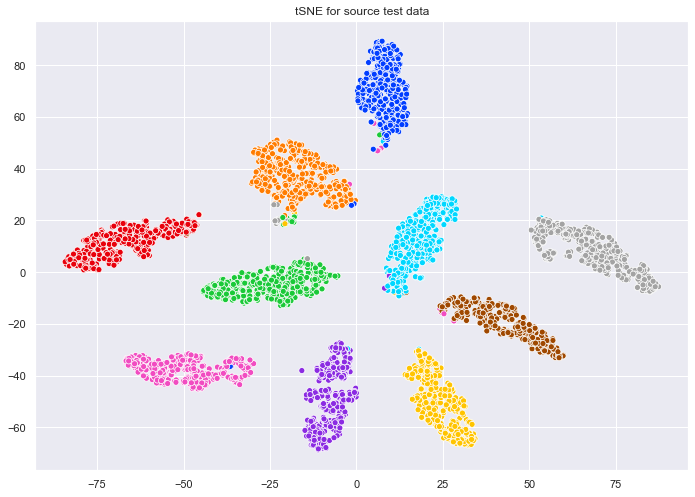

In [46]:
# Evalualtion

from sklearn.manifold import TSNE
import seaborn as sns

source_x_all = torch.empty(0,).to(device)
source_y_all = torch.empty(0,).to(device).long()
round_ = 0
total_round = 10
for batch_id, (source_x, source_y) in tqdm(enumerate(test_mnist_loader), total=len(test_mnist_loader)):
    optimizerCNet.zero_grad()
    optimizerEncoder.zero_grad()
    source_x = source_x.to(device).float()
    source_y = source_y.to(device)
    source_x_all = torch.cat([source_x_all, source_x], dim=0)
    source_y_all = torch.cat([source_y_all, source_y], dim=0)
    round_ += 1
    if round_ >= total_round:
        break

CNet.eval()
encoder.eval()
CNet.to(device)
encoder.to(device)
source_x_embedding_all = encoder(source_x_all)
last_layer = CNet(source_x_embedding_all)
source_x_embedding_all.shape


tsne = TSNE()
tsne_res = tsne.fit_transform(source_x_embedding_all.to('cpu').detach())

# plot
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

g = sns.scatterplot(tsne_res[:,0], tsne_res[:,1], hue=source_y_all.to('cpu'), legend=False, palette=palette)

plt.title('tSNE for source test data')


  5%|▍         | 9/184 [00:00<00:14, 11.95it/s]


Text(0.5, 1.0, 'tSNE for target testing data')

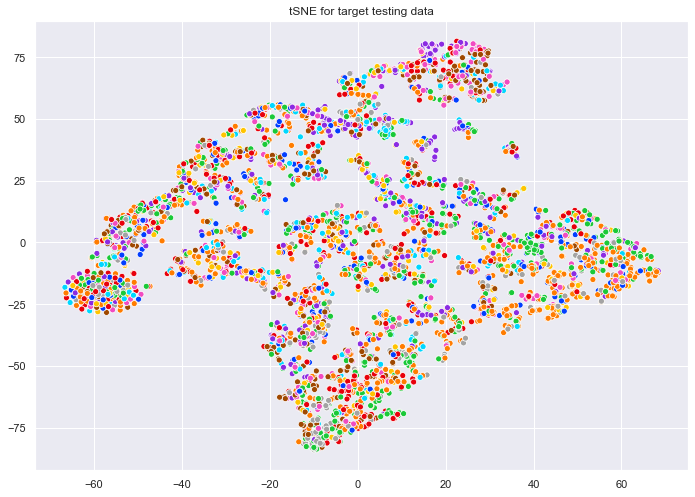

In [44]:

target_x_all = torch.empty(0,).to(device)
target_y_all = torch.empty(0,).to(device).long()
round_ = 0
total_round = 10
for batch_id, (target_x, target_y) in tqdm(enumerate(test_svhn_loader), total=len(test_svhn_loader)):
    optimizerCNet.zero_grad()
    optimizerEncoder.zero_grad()
    target_x = target_x.to(device).float()
    target_y = target_y.to(device)
    target_x_all = torch.cat([target_x_all, target_x], dim=0)
    target_y_all = torch.cat([target_y_all, target_y], dim=0)
    round_ += 1
    if round_ >= total_round:
        break

CNet.eval()
encoder.eval()
CNet.to(device)
encoder.to(device)
target_x_embedding_all = encoder(target_x_all)
last_layer = CNet(target_x_embedding_all)
target_x_embedding_all.shape


target_tsne = TSNE()
target_tsne_res = target_tsne.fit_transform(last_layer.to('cpu').detach())

# plot
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

g = sns.scatterplot(target_tsne_res[:,0], target_tsne_res[:,1], hue=target_y_all.to('cpu'), legend=False, palette=palette)

plt.title('tSNE for target testing data')